In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
import keras
from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import metrics
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
from keras.metrics import AUC
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing import image
from keras.callbacks import LearningRateScheduler, EarlyStopping

Image Preprocessing

In [2]:
# Set the path to your dataset
BASE_PATH_TRAIN = "C:\\DL Testing Set"
BASE_PATH_TEST = "C:\\kaggle\\input\\ArTaxOr"


# Step 1: Image Preprocessing
image_train = []
labels_train = []

for root, dirs, files in os.walk(BASE_PATH_TRAIN):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image_train.append(os.path.join(root, file))
                labels_train.append(label)

data_train = {'Images': image_train, 'labels': labels_train}
data_train = pd.DataFrame(data_train)

lb = LabelEncoder()
data_train['encoded_labels'] = lb.fit_transform(data_train['labels'])

image_test = []
labels_test = []

for root, dirs, files in os.walk(BASE_PATH_TEST):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image_test.append(os.path.join(root, file))
                labels_test.append(label)

data_test = {'Images': image_test, 'labels': labels_test}
data_test = pd.DataFrame(data_test)

data_test['encoded_labels'] = lb.transform(data_test['labels'])

In [3]:
# Number of classes (insects)
num_classes = len(lb.classes_)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create data generator
batch_size = 128

In [4]:
# Define a data generator for training and validation
datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=45,  # Increase rotation range
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    validation_split=0.2
)

# Define a data generator for testing
test_gen = ImageDataGenerator(rescale=1./255.)

# Training Data Generator

train_generator = datagen.flow_from_dataframe(
    dataframe=data_train,
    x_col="Images",
    y_col="labels",
    subset="training",
    batch_size=batch_size,
    seed=42,
    class_mode="categorical",
    target_size=(224, 224)
)

# Validation Data Generator
val_generator = datagen.flow_from_dataframe(
    dataframe=data_train,
    x_col="Images",
    y_col="labels",
    subset="validation",
    batch_size=batch_size,
    seed=42,
    class_mode="categorical",
    target_size=(224, 224)
)

train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
test_gen = ImageDataGenerator(rescale=(1./255.))

Found 11496 validated image filenames belonging to 7 classes.
Found 2874 validated image filenames belonging to 7 classes.


Model Modification for Insect Classification

In [5]:
# Step 2: Model Modification for Insect Classification

from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense

def get_mobilenet_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model



In [6]:
# Create the model
mobile_model = get_mobilenet_model(num_classes)

In [17]:
mobile_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

Training the Insect Classification Model

In [7]:
from keras.models import load_model

# Compile the model
mobile_model.compile(loss="categorical_crossentropy",
                      optimizer=SGD(learning_rate=0.001, momentum=0.9),
                      metrics=['accuracy', metrics.Recall(), metrics.Precision(), metrics.AUC()])

# Train AlexNet
history_mobile = mobile_model.fit(
    train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, 
                                  class_mode='categorical', subset='training'),
    epochs=12,
    validation_data=train_gen.flow_from_directory(train_dir, target_size=(224, 224), 
        batch_size=batch_size, class_mode='categorical', subset='validation')
    ,callbacks=[EarlyStopping(patience=3)]
)


# Save the model
mobile_model.save("C:/Deep Learning/Project/Classification Models/mobmobilenet_model.h5")

# Save training history to a CSV file
history_df = pd.DataFrame(history_mobile.history)
history_df.to_csv("C:/Deep Learning/Project/Classification Models/mobmobilenet_history.csv", index=False)



Found 11628 images belonging to 7 classes.
Found 2902 images belonging to 7 classes.
Epoch 1/12
91/91 [==============================] - 8426s 93s/step - loss: 1.2412 - accuracy: 0.5949 - recall: 0.4602 - precision: 0.7397 - auc: 0.8650 - val_loss: 0.9862 - val_accuracy: 0.6744 - val_recall: 0.6010 - val_precision: 0.7737 - val_auc: 0.9162
Epoch 2/12
91/91 [==============================] - 4526s 50s/step - loss: 0.8454 - accuracy: 0.7239 - recall: 0.6337 - precision: 0.8343 - auc: 0.9372 - val_loss: 0.9110 - val_accuracy: 0.6909 - val_recall: 0.6141 - val_precision: 0.7802 - val_auc: 0.9294
Epoch 3/12
91/91 [==============================] - 4614s 51s/step - loss: 0.7534 - accuracy: 0.7542 - recall: 0.6615 - precision: 0.8493 - auc: 0.9504 - val_loss: 0.8822 - val_accuracy: 0.7030 - val_recall: 0.6330 - val_precision: 0.7797 - val_auc: 0.9344
Epoch 4/12
91/91 [==============================] - 4558s 50s/step - loss: 0.7018 - accuracy: 0.7685 - recall: 0.6844 - precision: 0.8571 - auc:

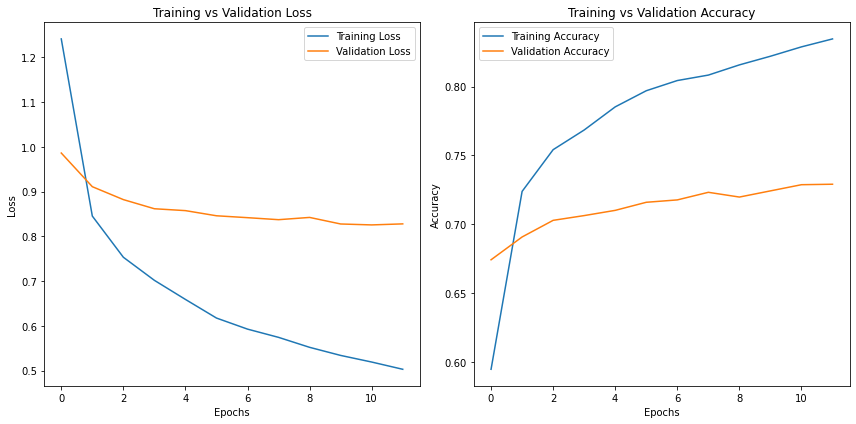

In [8]:
import pandas as pd
import matplotlib.pyplot as plt 

# Load the data from the CSV file
file_path = "C:/Deep Learning/Project/Classification Models/mobmobilenet_history.csv"  # Update with the correct file path
history_data = pd.read_csv(file_path)

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Testing Prediction on Unlabeled Images

1/1 [==============================] - 2s 2s/step


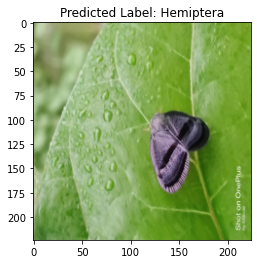

Predicted Label for the New Image: Hemiptera


In [9]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobmobilenet_model.h5")


# Specify the path to the new, unlabeled image
new_image_path = "C:/DL Small Set/Hemiptera/IMG_20210928_072325.jpg"

# Load and preprocess the new image
new_image = Image.open(new_image_path)
new_image = new_image.resize((224, 224))
new_image_array = np.array(new_image) / 255.0  # Normalize pixel values
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

# Make predictions on the new image
new_image_prediction = loaded_model.predict(new_image_array)

# Convert the prediction to a class label
predicted_label = lb.inverse_transform(new_image_prediction.argmax(axis=1))[0]

# Display the new image along with the predicted label
plt.imshow(new_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

print("Predicted Label for the New Image:", predicted_label)


1/1 [==============================] - 1s 1s/step


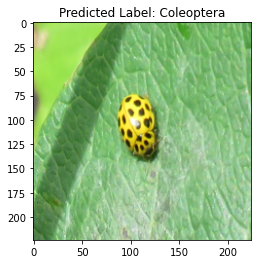

Predicted Label for the New Image: Coleoptera


In [10]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobmobilenet_model.h5")



# Specify the path to the new, unlabeled image
new_image_path = "C:/kaggle/input/ArTaxOr/Coleoptera/0bd077deb271.jpg"

# Load and preprocess the new image
new_image = Image.open(new_image_path)
new_image = new_image.resize((224, 224))
new_image_array = np.array(new_image) / 255.0  # Normalize pixel values
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

# Make predictions on the new image
new_image_prediction = loaded_model.predict(new_image_array)

# Convert the prediction to a class label
predicted_label = lb.inverse_transform(new_image_prediction.argmax(axis=1))[0]

# Display the new image along with the predicted label
plt.imshow(new_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

print("Predicted Label for the New Image:", predicted_label)


1/1 [==============================] - 2s 2s/step


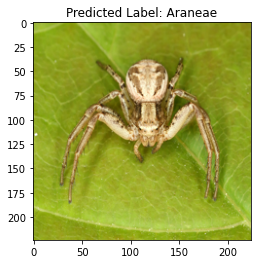

Predicted Label for the New Image: Araneae


In [11]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobmobilenet_model.h5")

# Specify the path to the new, unlabeled image
new_image_path = "C:/kaggle/input/ArTaxOr/Araneae/fa6b4011c1f0.jpg"

# Load and preprocess the new image
new_image = Image.open(new_image_path)
new_image = new_image.resize((224, 224))
new_image_array = np.array(new_image) / 255.0  # Normalize pixel values
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

# Make predictions on the new image
new_image_prediction = loaded_model.predict(new_image_array)

# Convert the prediction to a class label
predicted_label = lb.inverse_transform(new_image_prediction.argmax(axis=1))[0]

# Display the new image along with the predicted label
plt.imshow(new_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

print("Predicted Label for the New Image:", predicted_label)


# Testing Prediction on Mobile Corpus

In [13]:
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have train_gen and test_gen already defined as ImageDataGenerator instances
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
test_gen = ImageDataGenerator(rescale=(1./255.))

# Specify the path to the test set
test_dir = "C:\\DL Testing Set"

# Evaluate the model on the test set
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])


Found 14530 images belonging to 7 classes.
114/114 [==============================] - 4825s 42s/step - loss: 0.5112 - accuracy: 0.8350 - recall: 0.7801 - precision: 0.8920 - auc: 0.9766
Test Loss: 0.5111863613128662
Test Accuracy: 0.8349621295928955


In [ ]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobmobilenet_model.h5")

# Modify the DataFrame to include the filepath for each image and assign a number to each image
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for index, row in data.iterrows()]
data['image_number'] = range(1, len(data) + 1)

# Select 15 random images
random_image_numbers = np.random.choice(data['image_number'], size=15, replace=False)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i, image_number in enumerate(random_image_numbers):
    # Retrieve path and true label
    selected_image = data[data['image_number'] == image_number]
    img_path = selected_image['filepaths'].values[0]
    true_label = lb.inverse_transform([selected_image['encoded_labels'].values[0]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()

# Specify the path to the test set
test_dir = "C:\\DL Testing Set"

# Evaluate the model on the test set
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

# Test on ArTaxOr

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have train_gen and test_gen already defined as ImageDataGenerator instances
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
test_gen = ImageDataGenerator(rescale=(1./255.))

# Specify the path to the test set
test_dir = "C:\\kaggle\\input\\ArTaxOr"

# Evaluate the model on the test set
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

Found 15376 images belonging to 7 classes.
121/121 [==============================] - 1762s 15s/step - loss: 1.4959 - accuracy: 0.5047 - recall: 0.4095 - precision: 0.6046 - auc: 0.8300
Test Loss: 1.4959290027618408
Test Accuracy: 0.5047476291656494


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model


# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobmobilenet_model.h5")

# Set the path to the test set
test_dir = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 128

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("Inceptionv3 Test Loss:", test_results[0])
print("Inceptionv3 Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()

# A mixture of images from both datasets - ArTaxOR and Mobile Corpus

In [15]:
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have train_gen and test_gen already defined as ImageDataGenerator instances
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
test_gen = ImageDataGenerator(rescale=(1./255.))

# Specify the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"

# Evaluate the model on the test set
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

Found 229 images belonging to 7 classes.
2/2 [==============================] - 58s 26s/step - loss: 1.0495 - accuracy: 0.6288 - recall: 0.5371 - precision: 0.7593 - auc: 0.9073
Test Loss: 1.0495166778564453
Test Accuracy: 0.6288209557533264


In [ ]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobmobilenet_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 128

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))


# Display the evaluation results
print("Inception_Mod Test Loss:", test_results[0])
print("Inception_Mod Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()


# Confusion Matrix for Mobile-ArTaxOR Mix set

          labels  encoded_labels
0        Araneae               0
31    Coleoptera               1
66       Diptera               2
96     Hemiptera               3
130  Hymenoptera               4
164  Lepidoptera               5
196      Odonata               6
1/1 [==============================] - 0s 104ms/step


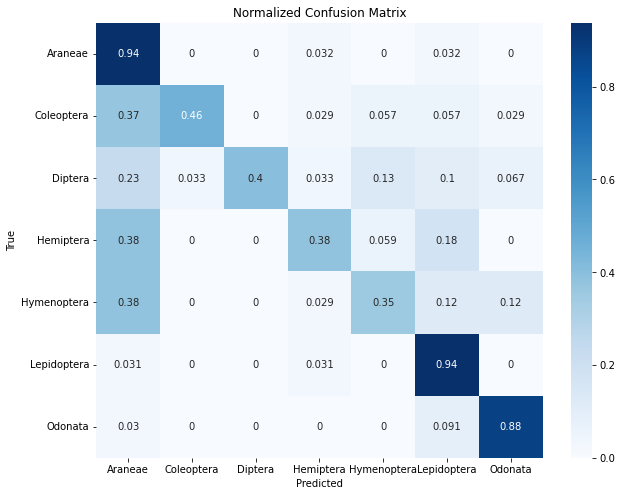

Classification Report:
              precision    recall  f1-score   support

     Araneae       0.38      0.94      0.54        31
  Coleoptera       0.94      0.46      0.62        35
     Diptera       1.00      0.40      0.57        30
   Hemiptera       0.72      0.38      0.50        34
 Hymenoptera       0.60      0.35      0.44        34
 Lepidoptera       0.61      0.94      0.74        32
     Odonata       0.81      0.88      0.84        33

    accuracy                           0.62       229
   macro avg       0.72      0.62      0.61       229
weighted avg       0.72      0.62      0.61       229



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobmobilenet_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 128

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))


# Confusion Matrix for ArTaxOr

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt


# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobmobilenet_model.h5")

# Set the path to the test set
test_dir = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 128

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))

# COnfusion Matrix for Mobile Corpus

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobmobilenet_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Testing Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Testing Set"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 128

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))

In [17]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             